In [1]:
import sys
sys.path.append("..")

from matplotlib import pyplot as plt

import torch
import numpy as np
from torch.distributions import Beta

import pyro
from pyro.infer.mcmc import MCMC
from pyro.infer import NUTS
import pyro.distributions as dist
from pyro.infer.mcmc import HMC as HMC_Pyro

from kernel.hmc import HMC as HMC_Local
from kernel.sghmc import SGHMC as SGHMC_Local
from kernel.sgnuts import NUTS as NUTS_Local

In [2]:
pyro.clear_param_store()

pyro.set_rng_seed(101)

# create some data with 6 observed heads and 4 observed tails
x1 = torch.ones(10)
x1[0:6] = torch.zeros(6)

x2 = torch.ones(10)
x2[0:2] = torch.zeros(2)

    
def model(x1, x2, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f1 = pyro.sample("coin1", dist.Beta(alpha0, beta0))
    f2 = pyro.sample("coin2", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs1", dist.Bernoulli(f1), obs=x1), pyro.sample("obs2", dist.Bernoulli(f2), obs=x2)

In [3]:
hmc_local = HMC_Local(model, step_size=0.1, num_steps=5, do_step_size_adaptation=True, target_accept=0.8)
mcmc_local = MCMC(hmc_local, num_samples=1000)
mcmc_local.run(x1, x2)
samples_local = mcmc_local.get_samples()

Sample: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:24, 80.75it/s, step size=7.56e-01]


In [27]:
BATCH_SIZE = 5

sghmc_local = SGHMC_Local(model,
                          subsample_positions=[0, 1],
                          batch_size=BATCH_SIZE,
                          learning_rate=0.01,
                          momentum_decay= 0.1,
                          num_steps=10,
                          resample_every_n=50,
                          obs_info_noise=True,
                          compute_obs_info='every_sample')

sg_mcmc_local = MCMC(sghmc_local, num_samples=1000)
sg_mcmc_local.run(x1, x2)
sg_samples_local = sg_mcmc_local.get_samples()

Sample: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:41, 48.54it/s, lr=1.00e-02]


In [5]:
BATCH_SIZE = 5

nuts_local = NUTS_Local(model,
                        subsample_positions=[0, 1],
                        batch_size=BATCH_SIZE,
                        step_size=0.1,
                        resample_every_n=50,
                        with_friction=True,
                        friction_constant=1.0,
                        friction_term=None,
                        obs_info_noise=False,
                        compute_obs_info='start',
                        do_mh_correction=False,
                        target_accept = 0.8,
                        use_multinomial_sampling=True,
                        max_tree_depth=10,
                        do_step_size_adaptation=False)                  

nuts_mcmc_local = MCMC(nuts_local, num_samples=1000)
nuts_mcmc_local.run(x1, x2)
nuts_samples_local = nuts_mcmc_local.get_samples()

Sample: 100%|████████████████████████████████████████████████████████| 2000/2000 [01:54, 17.45it/s, step size=1.00e-01]


In [6]:
hmc_pyro = HMC_Pyro(model)
mcmc_pyro = MCMC(hmc_pyro, num_samples=1000)
mcmc_pyro.run(x1, x2)
samples_pyro = mcmc_pyro.get_samples()

Sample: 100%|███████████████████████████████████████| 2000/2000 [00:31, 63.89it/s, step size=8.99e-01, acc. prob=0.916]


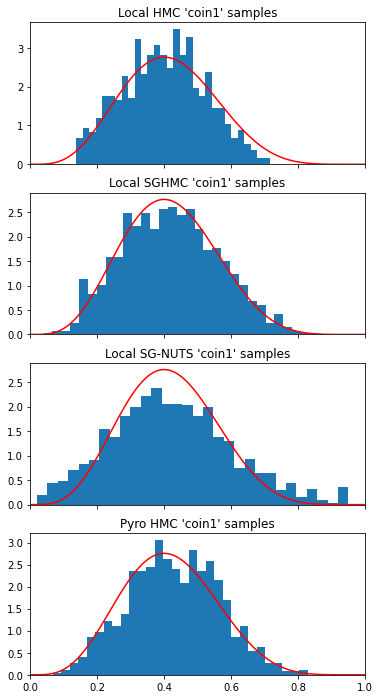

In [28]:
fig, axs = plt.subplots(4, 1, figsize=(6, 12), sharex=True)

def analytic_posterior(x):
    fn = Beta(5., 7.)
    return np.exp(fn.log_prob(x))
    
x = torch.tensor(np.linspace(0, 1, num=1000))

with torch.no_grad():
    axs[0].hist(samples_local["coin1"].numpy(), density=True, bins=30)
    axs[0].set(title="Local HMC 'coin1' samples")
    axs[0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1].hist(sg_samples_local["coin1"].numpy(), density=True, bins=30)
    axs[1].set(title="Local SGHMC 'coin1' samples")
    axs[1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[2].hist(nuts_samples_local["coin1"].numpy(), density=True, bins=30)
    axs[2].set(title="Local SG-NUTS 'coin1' samples")
    axs[2].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[3].hist(samples_pyro["coin1"].numpy(), density=True, bins=30)
    axs[3].set(title="Pyro HMC 'coin1' samples")
    axs[3].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    
plt.xlim((0.0, 1.0))
plt.show()
#posterior samples should look like a beta(5, 7) dist

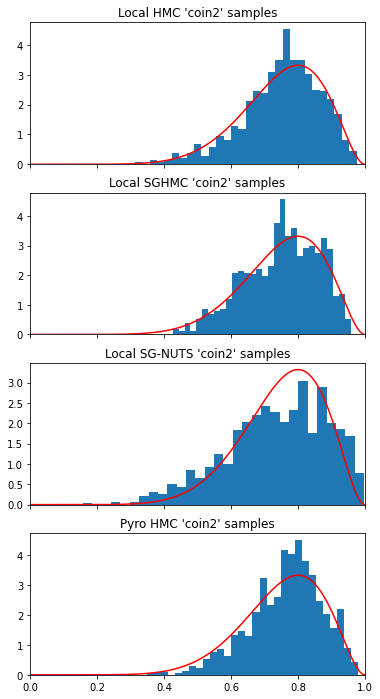

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(6, 12), sharex=True)

def analytic_posterior(x):
    fn = Beta(9., 3.)
    return np.exp(fn.log_prob(x))
    
x = torch.tensor(np.linspace(0, 1, num=1000))

with torch.no_grad():
    axs[0].hist(samples_local["coin2"].numpy(), density=True, bins=30)
    axs[0].set(title="Local HMC 'coin2' samples")
    axs[0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1].hist(sg_samples_local["coin2"].numpy(), density=True, bins=30)
    axs[1].set(title="Local SGHMC 'coin2' samples")
    axs[1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[2].hist(nuts_samples_local["coin2"].numpy(), density=True, bins=30)
    axs[2].set(title="Local SG-NUTS 'coin2' samples")
    axs[2].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[3].hist(samples_pyro["coin2"].numpy(), density=True, bins=30)
    axs[3].set(title="Pyro HMC 'coin2' samples")
    axs[3].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    
plt.xlim((0.0, 1.0))    
plt.show()
#posterior samples should look like a beta(9, 3) dist